## CvT

- 데이터세트는 앞선 ViT 예제의 코드 활용

In [1]:
### 앞선 ViT 예제의 코드 - 데이터세트 불러오기 등

from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets


def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)


train_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=True)
test_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

subset_train_dataset = subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset = subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.74MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.4MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [2]:
### 이미지 데이터 전처리
# CvT는 가장 짧은 이미지 길이로 정규화해 사용

import torch
from torchvision import transforms
from transformers import AutoImageProcessor

# 모델명 변경
image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="microsoft/cvt-21"
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["shortest_edge"],  # ViT: size["height"]
                image_processor.size["shortest_edge"]   # ViT: size["width"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
from torch.utils.data import DataLoader


def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}


train_dataloader = DataLoader(
    subset_train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=lambda x: collator(x, transform),
    drop_last=True
)
valid_dataloader = DataLoader(
    subset_test_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda x: collator(x, transform),
    drop_last=True
)

### 모델 구조 확인

In [4]:
### 사전 학습된 CvT 모델

from transformers import CvtForImageClassification


model = CvtForImageClassification.from_pretrained(
    pretrained_model_name_or_path="microsoft/cvt-21",
    num_labels=len(train_dataset.classes),
    id2label={idx: label for label, idx in train_dataset.class_to_idx.items()},
    label2id=train_dataset.class_to_idx,
    ignore_mismatched_sizes=True
)

for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("   └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("     └", sssub_name)


config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/127M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/127M [00:00<?, ?B/s]

Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cvt
└ encoder
   └ stages
     └ 0
     └ 1
     └ 2
layernorm
classifier


- 세 개의 스테이지로 구성된 cvt, 계층 정규화, 분류기로 구성
- 스윈 트랜스포머와의 차이점 1: 분류기(classifier) 이전에 풀링(pooler) 계층 X
  : CvT는 이미 Conv layer를 활용해 지역 특징 정보, 전역 정보 파악하기 때문
- 스윈 트랜스포머와의 차이점 2: 스테이지별 이미지 크기, 임베딩 차원
  : 이미지 사이즈 - 스테이지별로 4배, 8배, 16배 감소
  : 임베딩 차원 - 이미지 사이즈와 반비례하게 커짐

In [5]:
### CvT 모델의 스테이지 구조 출력

stages = model.cvt.encoder.stages
print(stages[0])

CvtStage(
  (embedding): CvtEmbeddings(
    (convolution_embeddings): CvtConvEmbeddings(
      (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
      (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (layers): Sequential(
    (0): CvtLayer(
      (attention): CvtAttention(
        (attention): CvtSelfAttention(
          (convolution_projection_query): CvtSelfAttentionProjection(
            (convolution_projection): CvtSelfAttentionConvProjection(
              (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
              (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (linear_projection): CvtSelfAttentionLinearProjection()
          )
          (convolution_projection_key): CvtSelfAttentionProjection(
            (convolution_projection): CvtSelfAtte

- 각 스테이지는 크게 CvtEmbdeeings와 CvtLayer로 구성
  - CvtEmbeddings: 입력 이미지에 대한 2D 합성곱 연산, 계층 정규화로 이루어짐
    - 이미지를 패치 단위로 잘라 임베딩하는 역할
    - 입력 이미지는 첫 번째 스테이지의 CvtEmbeddings에 적용됨
  - Cvtlayer: 이미지 패치에 대한 셀프 어텐션 수행

In [6]:
### 셀프 어텐션 적용

batch = next(iter(train_dataloader))
print("이미지 차원 :", batch["pixel_values"].shape)

patch_emb_output = stages[0].embedding(batch["pixel_values"])
print("패치 임베딩 차원 :", patch_emb_output.shape)

batch_size, num_channels, height, width = patch_emb_output.shape
hidden_state = patch_emb_output.view(batch_size, num_channels, height * width).permute(0, 2, 1)
print("셀프 어텐션 입력 차원 :", hidden_state.shape)

attention_output = stages[0].layers[0].attention.attention(hidden_state, height, width)
print("셀프 어텐션 출력 차원 :", attention_output.shape)

이미지 차원 : torch.Size([32, 3, 224, 224])
패치 임베딩 차원 : torch.Size([32, 64, 56, 56])
셀프 어텐션 입력 차원 : torch.Size([32, 3136, 64])
셀프 어텐션 출력 차원 : torch.Size([32, 3136, 64])


- 모듈의 입력 차원과 출력 차원이 동일함을 확인할 수 O

## CvT 모델 학습: 이것만 실행해도 됨

- ViT 코드를 일부 변경(변경점은 표시)

In [8]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.

In [10]:
import torch
import evaluate
import numpy as np
from itertools import chain
from collections import defaultdict
from torch.utils.data import Subset
from torchvision import datasets
from torchvision import transforms
from transformers import AutoImageProcessor
from transformers import CvtForImageClassification
from transformers import TrainingArguments, Trainer


def subset_sampler(dataset, classes, max_len):
    target_idx = defaultdict(list)
    for idx, label in enumerate(dataset.train_labels):
        target_idx[int(label)].append(idx)

    indices = list(
        chain.from_iterable(
            [target_idx[idx][:max_len] for idx in range(len(classes))]
        )
    )
    return Subset(dataset, indices)


def model_init(classes, class_to_idx):
    model = CvtForImageClassification.from_pretrained(
        pretrained_model_name_or_path="microsoft/cvt-21",
        num_labels=len(classes),
        id2label={idx: label for label, idx in class_to_idx.items()},
        label2id=class_to_idx,
        ignore_mismatched_sizes=True
    )
    return model


def collator(data, transform):
    images, labels = zip(*data)
    pixel_values = torch.stack([transform(image) for image in images])
    labels = torch.tensor([label for label in labels])
    return {"pixel_values": pixel_values, "labels": labels}


def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = metric.compute(
        predictions=predictions, references=labels, average="macro"
    )
    return macro_f1


train_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=True)
test_dataset = datasets.FashionMNIST(root="../datasets", download=True, train=False)

classes = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

subset_train_dataset = subset_sampler(
    dataset=train_dataset, classes=train_dataset.classes, max_len=1000
)
subset_test_dataset = subset_sampler(
    dataset=test_dataset, classes=test_dataset.classes, max_len=100
)

image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path="microsoft/cvt-21"
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            size=(
                image_processor.size["shortest_edge"],
                image_processor.size["shortest_edge"]
            )
        ),
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0)
        ),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std
        )
    ]
)

args = TrainingArguments(
    output_dir="../models/CvT-FashionMNIST",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="log_dir",
    logging_steps=125,
    remove_unused_columns=False,
    seed=7,
    report_to="none"  # 코랩일 경우 실행(API 입력 안해도 되게)
)

trainer = Trainer(
    model_init=lambda x: model_init(classes, class_to_idx),
    args=args,
    train_dataset=subset_train_dataset,
    eval_dataset=subset_test_dataset,
    data_collator=lambda x: collator(x, transform),
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
)
trainer.train()


<ipython-input-10-6b1ec94ab2b8>:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([10, 384]) in the model ins

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,F1
1,0.810700,0.335632,0.881078
2,0.685300,0.273192,0.908556
3,0.678000,0.261133,0.915485


TrainOutput(global_step=1875, training_loss=0.7924824788411459, metrics={'train_runtime': 690.3662, 'train_samples_per_second': 43.455, 'train_steps_per_second': 2.716, 'total_flos': 8.4649093853184e+17, 'train_loss': 0.7924824788411459, 'epoch': 3.0})

PredictionOutput(predictions=array([[ 6.6663904 , -1.7864366 ,  0.16567552, ..., -1.5248764 ,
        -0.03368336, -1.7771143 ],
       [ 3.7951837 , -0.46277034, -0.0882564 , ..., -1.7817246 ,
        -1.0743141 , -1.6649818 ],
       [ 6.9261622 , -1.5404541 ,  0.21243332, ..., -1.1554493 ,
        -0.7047764 , -1.8242311 ],
       ...,
       [-1.2845644 , -1.3594656 , -0.6077229 , ...,  1.6724088 ,
        -0.3342987 ,  5.1287746 ],
       [-1.3264189 , -0.6722602 , -0.17670582, ...,  0.93183035,
        -1.0376673 ,  6.8011603 ],
       [-1.5665582 , -0.28587505, -0.5701715 , ..., -0.49373475,
        -0.18160285,  6.890667  ]], dtype=float32), label_ids=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

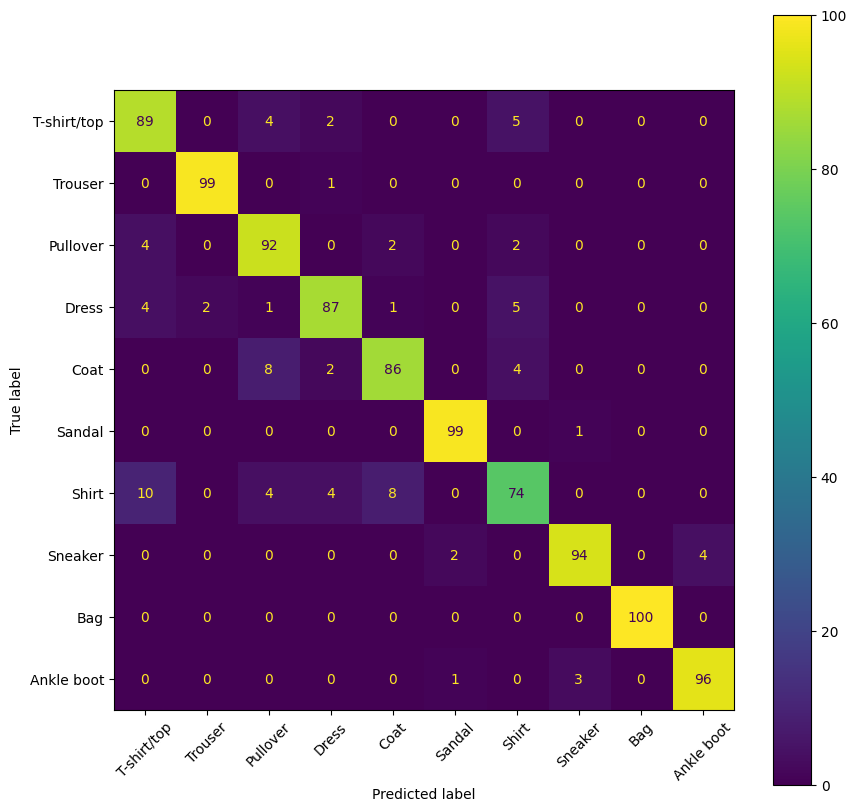

In [11]:
### 모델 평가(ViT 코드 활용)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


outputs = trainer.predict(subset_test_dataset)
print(outputs)

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(classes)
matrix = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
_, ax = plt.subplots(figsize=(10, 10))
display.plot(xticks_rotation=45, ax=ax)
plt.show()
